## Ramp controlling load up curves

In [107]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 29 2025

@author: danap
"""

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# -----------------------------
# User settings
# -----------------------------
START = '3:00'
STOP = '6:00'
tres = 3
tres = str(tres)


WORKING_DIR = r"C:\Users\danap\OCHRE_Working"
power_col = 'Water Heating Electric Power (kW)'
t_col = 'Water Heating Control Temperature (C)'
time_col = 'Time'
home_col = 'Home'

baseline_file = os.path.join(WORKING_DIR, "180109_2_3_RCJ_Baseline.csv")
control_file = os.path.join(WORKING_DIR, "180109_2_3_NR_Controlled.csv")
# control_file = os.path.join(WORKING_DIR, '180111_1_3_RC_4whAgg_contr.csv')

# -----------------------------
# Load data
# -----------------------------
df_base = pd.read_csv(baseline_file)
df_control = pd.read_csv(control_file)



df_base['Time'] = pd.to_datetime(df_base[time_col])
df_control['Time'] = pd.to_datetime(df_control[time_col])


def ET(TC, COP, Tset):
    """Energy take calculation."""
    TF = (9/5 * TC) + 32 
    
    c = 0.291
    p = 8.3454
    V = 50
    return c * p * V * (Tset - TF) / (COP*1000)


df_base['ET'] = df_base.apply(lambda row: ET(row['Water Heating Control Temperature (C)'], 3.2, 130), axis=1)
df_control['ET'] = df_control.apply(lambda row: ET(row['Water Heating Control Temperature (C)'], 3.2, 130), axis=1)

# -----------------------------
# Filter Time of interest
# -----------------------------
start_time = pd.to_datetime(START).time()
end_time   = pd.to_datetime(STOP).time()

df_base_window = df_base[df_base['Time'].dt.time.between(start_time, end_time)]
df_control_window = df_control[df_control['Time'].dt.time.between(start_time, end_time)]

# -----------------------------
# Aggregate across homes by time
# -----------------------------
# agg_base = df_base_window.groupby(df_base_window['Time'].dt.time).agg({
#     power_col: 'sum',
#     'ET': 'sum'})   # Add ET here
# agg_control = df_control_window.groupby(df_control_window['Time'].dt.time).agg({
#     power_col: 'sum',
#     'ET': 'sum'})

# Set index
df_base_window = df_base_window.set_index('Time')
df_control_window = df_control_window.set_index('Time')

agg_base = df_base_window.groupby('Time').sum()  # sums across homes
agg_control = df_control_window.groupby('Time').sum()


# Extract arrays for processing
Pb = agg_base[power_col].to_numpy()
ETb = agg_base['ET'].to_numpy()
Pc = agg_control[power_col].to_numpy()
ETc = agg_control['ET'].to_numpy()
time_index_15min = agg_base.index

print("Done: Pb shape =", Pb.shape)


print('done')


Done: Pb shape = (122,)
done


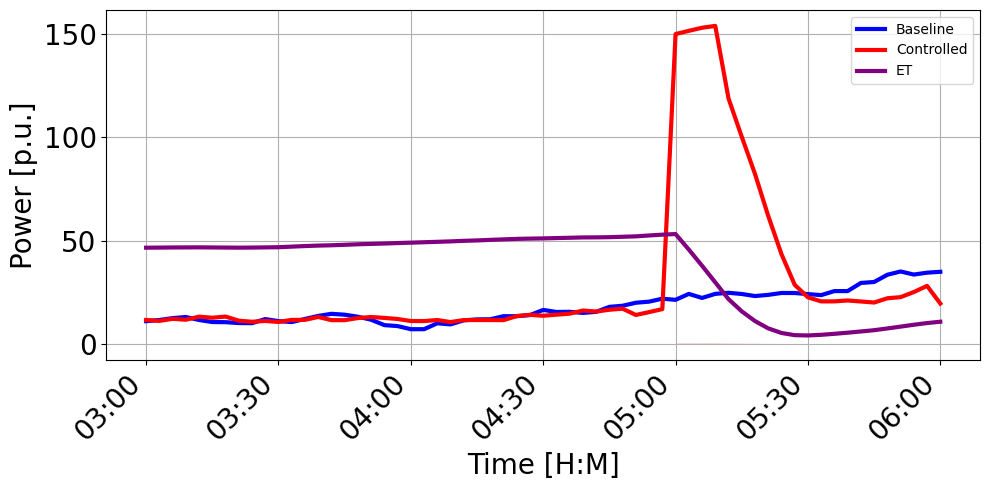

Area (3:00–6:00) between controlled and baseline: 237.96 kWh


In [108]:
A = 20
N = 409
days = 2
Prated = 0.5
N = N * Prated * days

# Filter datetime window
start_dt = pd.to_datetime(agg_base.index[0].date().strftime('%Y-%m-%d') + ' ' + START)
stop_dt = pd.to_datetime(agg_base.index[0].date().strftime('%Y-%m-%d') + ' ' + STOP)
df_base_window_plot = agg_base.loc[start_dt:stop_dt]
df_control_window_plot = agg_control.loc[start_dt:stop_dt]

time_index_plot = df_base_window_plot.index
Pb_plot = df_base_window_plot[power_col].to_numpy()
Pc_plot = df_control_window_plot[power_col].to_numpy()
ETc_plot = df_control_window_plot['ET'].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_index_plot, Pb_plot, label="Baseline", color='blue', linewidth=3)
ax.plot(time_index_plot, Pc_plot, label="Controlled", color='red', linewidth=3)
ax.plot(time_index_plot, ETc_plot, label="ET", color='purple', linewidth=3)

ax.set_xlabel("Time [H:M]", fontsize=A)
ax.set_ylabel("Power [p.u.]", fontsize=A)
ax.tick_params(axis='x', labelsize=A)
ax.tick_params(axis='y', labelsize=A)
ax.grid(True)
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.fill_between(time_index_plot, Pb_plot/N, Pc_plot/N,
                where=(Pb_plot/N < Pc_plot/N), alpha=1, linewidth=0, color='lightpink')

plt.tight_layout()
plt.show()

# -----------------------------
# Compute area between target output h[n] and input Pb
# -----------------------------
# Delta time in minutes between samples
dt = 15  # minutes

area_kWmin = np.trapz(np.abs(Pc_plot - Pb_plot), dx=dt)
area_Wh = area_kWmin / 60
print(f"Area (3:00–6:00) between controlled and baseline: {area_Wh:.2f} kWh")



Integer g[n] length: 12
Integer g[n] summing to 409: [15, 31, 34, 43, 60, 45, 40, 33, 29, 29, 28, 22]


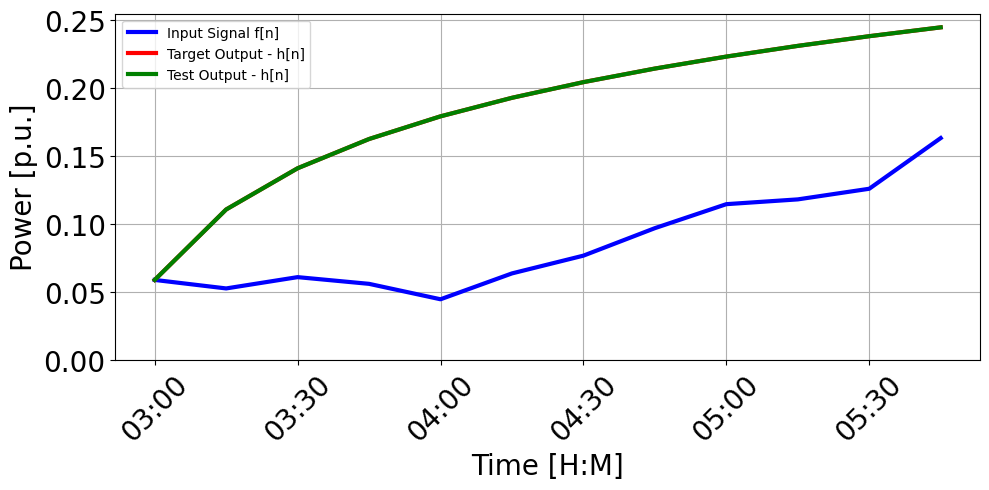

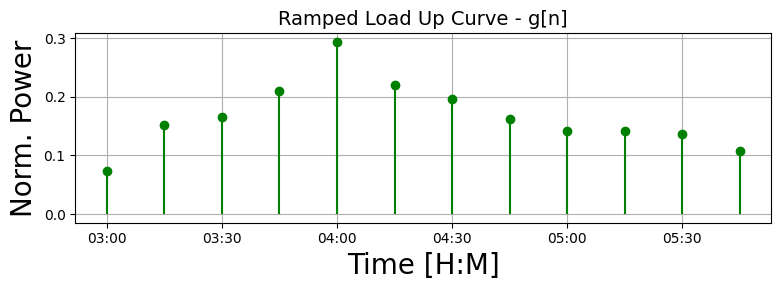

Area (3:00–6:00) between target and baseline: 57.67 kWh
Area (3:00–6:00) between controlled and baseline: 45.13 kWh


In [126]:
# -----------------------------
# Parameters for g[n] calculation
# -----------------------------
A = 38           # ramp magnitude
k = 409           # integer counts to scale
Prated = 0.5
days = 1
N = k * Prated * days  # normalization factor

# -----------------------------
# Select time window (3:00 - 6:00)
# -----------------------------
# Filter your window first
start_dt = pd.to_datetime(str(agg_base.index[0].date()) + ' 03:00')
stop_dt  = pd.to_datetime(str(agg_base.index[0].date()) + ' 06:00')
mask = (agg_base.index >= start_dt) & (agg_base.index < stop_dt)

Pb_window = agg_base[power_col][mask]
Pc_window = agg_control[power_col][mask]

# Downsample to 15-min intervals by taking the first value in each 15-min bin
Pb_plot = Pb_window.resample('15min').mean()
Pc_plot = Pc_window.resample('15min').mean()
time_index_plot = Pb_plot.index

# Convert to numpy arrays
Pb_plot = Pb_plot.to_numpy()
Pc_plot = Pc_plot.to_numpy()

num_steps = len(Pb_plot)  # should now be 12
Pb_start = Pb_plot[0]

# Target output
h_target = Pb_start + A * np.log(1 + np.arange(num_steps)) / np.log(num_steps)

# -----------------------------
# Compute g[n] safely
# -----------------------------
epsilon = 1e-6
Pb_safe = Pb_plot.copy()
Pb_safe[Pb_safe == 0] = epsilon

g_est = h_target / Pb_safe
# g_est = np.nan_to_num(g_est, nan=0.0, posinf=0.0, neginf=0.0)

# Scale g_est to integer counts summing to k
if g_est.sum() > 0:
    g_scaled = g_est / g_est.sum() * k
else:
    g_scaled = np.zeros_like(g_est)

g_int = np.floor(g_scaled).astype(int)
diff = k - g_int.sum()
if diff != 0:
    frac = g_scaled - np.floor(g_scaled)
    order = np.argsort(-frac)
    for i in order[:abs(diff)]:
        g_int[i] += np.sign(diff)

print("Integer g[n] length:", len(g_int))
print("Integer g[n] summing to 409:", list(g_int))

# -----------------------------
# Predicted output h_pred
# -----------------------------
h_pred = Pb_safe * g_est

# -----------------------------
# Plot signals
# -----------------------------
B = 20
plt.figure(figsize=(10,5))
plt.plot(time_index_plot, Pb_plot/N, label='Input Signal f[n]', color='blue', linewidth=3)
plt.plot(time_index_plot, h_target/N, label='Target Output - h[n]', color='red', linewidth=3)
plt.plot(time_index_plot, h_pred/N, label='Test Output - h[n]', color='green', linewidth=3)

plt.xlabel("Time [H:M]", fontsize=B)
plt.ylabel("Power [p.u.]", fontsize=B)
plt.tick_params(axis='x', labelsize=B)
plt.tick_params(axis='y', labelsize=B)
plt.ylim(bottom=0)
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot integer g[n]
# -----------------------------
plt.figure(figsize=(8,3))
plt.stem(time_index_plot, g_int/N, basefmt=" ", markerfmt='green', linefmt='green')
plt.xlabel("Time [H:M]", fontsize=B)
plt.ylabel("Norm. Power", fontsize=B)
plt.title("Ramped Load Up Curve - g[n]", fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Compute area between target output h[n] and input Pb
# -----------------------------
dt = 15  # minutes

area_kWmin = np.trapz(np.abs(h_target - Pb_plot), dx=dt)
area_Wh = area_kWmin / 60
print(f"Area (3:00–6:00) between target and baseline: {area_Wh:.2f} kWh")

area_kWmin = np.trapz(np.abs(Pc_plot - Pb_plot), dx=dt)
area_Wh = area_kWmin / 60
print(f"Area (3:00–6:00) between controlled and baseline: {area_Wh:.2f} kWh")


In [28]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# from sklearn.linear_model import Ridge
# from scipy.signal import correlate

# tres = 3
# duration = 3
# step_minutes = 3
# num_steps = int(duration * 60 / step_minutes) 
# print(num_steps)
# step_ratio = step_minutes // tres

# time_index_15min = pd.date_range(start=pd.Timestamp(START), periods=num_steps, freq=f"{step_minutes}min")

# # Compute 15-min average of Pb for plotting
# # Pb_15min = [Pb[i*step_ratio:(i+1)*step_ratio].mean() for i in range(num_steps)]
# Pb_15min = Pb.resample('15min').mean()

# # -----------------------------
# # Target output at 15-min resolution
# # -----------------------------

# ############## morning load up start
# Pb_start = Pb[0]
# A = 35  # ramp magnitude
# h_target = Pb_start + A * np.log(1 + np.arange(num_steps)) / np.log(num_steps)
# ############## morning load up end


# ############## mid day unload start
# # Pb_start = Pb[0]  # baseline
# # A = 95  - Pb[0]          # desired peak above baseline

# # # Step 1: define lengths
# # up_len = int(np.ceil(1/3 * num_steps))   # ramp-up duration
# # down_len = num_steps - up_len            # ramp-down duration

# # # Step 2: create log ramp-up
# # x_up = np.arange(up_len)
# # ramp_up = np.log(1 + x_up) / np.log(up_len)  # normalized 0→1

# # # Step 3: create ramp-down (mirror of last point of ramp_up)
# # x_down = np.arange(down_len)
# # ramp_down = ramp_up[-1] * (1 - x_down / (down_len - 1))  # linear decay from peak

# # # Step 4: combine
# # normalized_ramp = np.concatenate([ramp_up, ramp_down])

# # # Step 5: scale by A and shift by baseline
# # h_target = Pb_start + A * normalized_ramp
# ################# mid day unload end


# # -----------------------------
# # Linearize to find g[n]
# # -----------------------------

# # Compute g[n] directly
# g_est = h_target / Pb_15min  # element-wise division

# # Predicted output
# h_pred = Pb_15min * g_est


# # -----------------------------
# # Scale g_est to integer counts summing to k=409
# # -----------------------------
# k = 409
# if g_est.sum() > 0:
#     g_scaled = g_est / g_est.sum() * k
# else:
#     g_scaled = np.zeros_like(g_est)

# # Round and adjust to sum exactly k
# g_int = np.floor(g_scaled).astype(int)
# diff = k - g_int.sum()
# if diff != 0:
#     frac = g_scaled - np.floor(g_scaled)
#     order = np.argsort(-frac)
#     for i in order[:abs(diff)]:
#         g_int[i] += np.sign(diff)


# # -----------------------------
# # Print results
# # -----------------------------
# # print("Control Signal g[n] (float):", g_est)
# print("Integer g[n] summing to 409:", list(g_int))



# # -----------------------------
# # Plot signals
# # -----------------------------
# B = 20
# plt.figure(figsize=(10,5))
# plt.plot(time_index_15min, np.array(Pb_15min)/N, label='Input Signal f[n]', color='blue', linewidth=3)
# plt.plot(time_index_15min, np.array(h_target)/N, label='Target Output - h[n]', color='red', linewidth=3)
# plt.plot(time_index_15min, np.array(h_pred)/N, label="Test Output - h[n]", color='green', linewidth=3)
# # plt.plot(time_index_15min, np.array(h_pred)/N, label='Predicted Output (f[n] * g[n])', color='green', marker='x', markersize=15, linewidth=0)
# # plt.plot(time_index_15min, np.array(h_pred2)/N, label='Predicted Output (f[n] * g[n]2)', color='purple', marker='x', markersize=15, linewidth=0)



# plt.tick_params(axis='x', labelsize=B)
# plt.tick_params(axis='y', labelsize=B)
# plt.xlabel("Time [H:M]", fontsize=B)
# plt.ylabel("Power [p.u.]", fontsize=B)
# plt.ylim(bottom=0)
# ax = plt.gca()
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # -----------------------------
# # Plot integer g[n]
# # -----------------------------
# plt.figure(figsize=(8,3))
# plt.stem(np.arange(num_steps)*step_minutes, g_int/N, basefmt=" ",
#          markerfmt='green', linefmt='green')
# plt.xlabel("Time (minutes)", fontsize=B)
# plt.ylabel("Norm. Power", fontsize=B)
# plt.title("Ramped Load Up Curve - g[n]", fontsize=14)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

60


AttributeError: 'numpy.ndarray' object has no attribute 'resample'

In [ ]:
'180111_1_3_RC_4whAgg_contr.csv'

In [22]:
# -----------------------------
# Compute area between target output h[n] and input Pb
# -----------------------------
# Delta time in minutes between samples
dt3 = 3  # minutes
dt15  = 15
# Area = integral of |h[n] - Pb[n]|
area_between = np.trapz(np.abs(h_pred - Pb_15min), dx=dt15)
print(f"Area between h[n] and Pb: {area_between:.0f} kWh")


area_between = np.trapz(np.abs(Pc - Pb), dx=dt3)
print(f"Area between Pc and Pb: {area_between:.0f} kWh")



Area between h[n] and Pb: 2580 kWh
Area between Pc and Pb: 5520 kWh


# splash zone

Control Signal g[n] (float): [1.         1.88385216 2.27714106 2.70719686 2.75252203 3.35063094
 3.5390213  3.53931951 4.44415795 3.83792528 3.97651492 4.06769497]
Integer g[n] summing to 409: [33, 62, 75, 89, 90, 110, 116, 116, 146, 126, 131, 133]


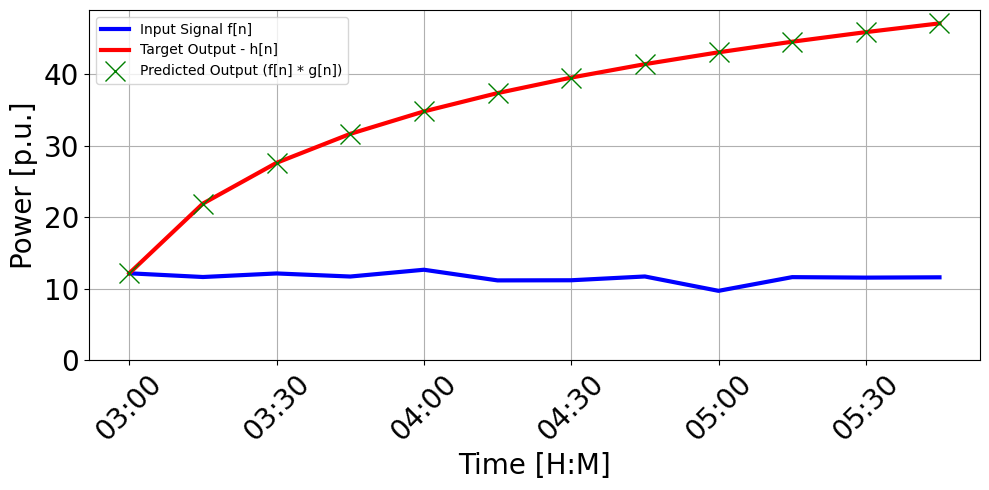

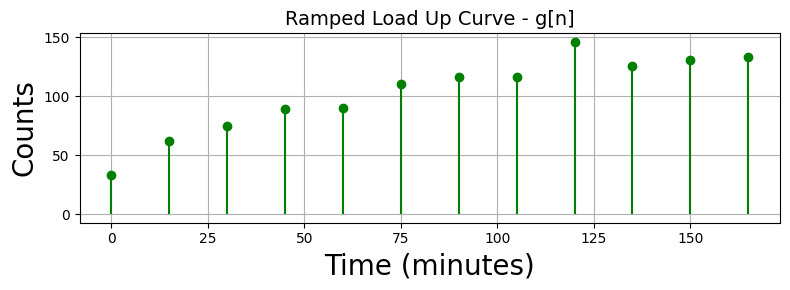

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# User-provided Pb from CSV aggregation
# -----------------------------
# Pb = np.array(agg_base)   # already aggregated baseline
Pb_step_minutes = 3
step_minutes = 15
num_steps = 12
step_ratio = step_minutes // Pb_step_minutes

time_index_15min = pd.date_range(start=pd.Timestamp(START), periods=num_steps, freq=f"{step_minutes}min")

# Compute 15-min average of Pb for plotting
Pb_15min = [Pb[i*step_ratio:(i+1)*step_ratio].mean() for i in range(num_steps)]

# -----------------------------
# Target output at 15-min resolution
# -----------------------------
Pb_start = Pb[0]
A = 35  # ramp magnitude
h_target = Pb_start + A * np.log(1 + np.arange(num_steps)) / np.log(num_steps)

# -----------------------------
# Build diagonal "system" F
# -----------------------------
# Compute 15-min averages directly
Pb_avg = np.array([Pb[i*step_ratio:(i+1)*step_ratio].mean() for i in range(num_steps)])

# Compute g[n] directly
g_est = h_target / Pb_avg  # element-wise division

# Predicted output
h_pred = Pb_avg * g_est



# -----------------------------
# Scale g_est to integer counts summing to k=409
# -----------------------------
k = 409
if g_est.sum() > 0:
    g_scaled = g_est / g_est.sum() * k
else:
    g_scaled = np.zeros_like(g_est)

# Round and adjust to sum exactly k
g_int = np.floor(g_scaled).astype(int)
diff = k - g_int.sum()
if diff != 0:
    frac = g_scaled - np.floor(g_scaled)
    order = np.argsort(-frac)
    for i in order[:abs(diff)]:
        g_int[i] += np.sign(diff)

# -----------------------------
# Compute predicted output
# -----------------------------


# -----------------------------
# Print results
# -----------------------------
print("Control Signal g[n] (float):", g_est)
print("Integer g[n] summing to 409:", list(g_int))

# -----------------------------
# Plot signals
# -----------------------------
B = 20
plt.figure(figsize=(10,5))
plt.plot(time_index_15min, np.array(Pb_15min), label='Input Signal f[n]', color='blue', linewidth=3)
plt.plot(time_index_15min, np.array(h_target), label='Target Output - h[n]', color='red', linewidth=3)
plt.plot(time_index_15min, np.array(h_pred), label='Predicted Output (f[n] * g[n])', color='green', marker='x', markersize=15, linewidth=0)

plt.tick_params(axis='x', labelsize=B)
plt.tick_params(axis='y', labelsize=B)
plt.xlabel("Time [H:M]", fontsize=B)
plt.ylabel("Power [p.u.]", fontsize=B)
plt.ylim(bottom=0)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot integer g[n]
# -----------------------------
plt.figure(figsize=(8,3))
plt.stem(np.arange(num_steps)*step_minutes, g_int, basefmt=" ",
         markerfmt='green', linefmt='green')
plt.xlabel("Time (minutes)", fontsize=B)
plt.ylabel("Counts", fontsize=B)
plt.title("Ramped Load Up Curve - g[n]", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
x = [5, 10, 15]

def func(x):
    return x + 2

for i in x:
    print(func(i))

7
12
17
